In [1]:
import os
import json
import uuid
from workflow_manager import WorkflowManager, MongoWorkflow

In [2]:
# Load the sample input json for the request
example_file = os.path.join(".", "workflow_input_example.txt")
with open(example_file) as f:
    input_json = json.load(f)
#input_json

In [3]:
%%time
# Initialize the workflow class object and inputs
sim_id = str(uuid.uuid4())
debug = True
local = True
workflow = WorkflowManager(
    task_id=sim_id,
    sim_input=input_json["sim_input"],
    order=input_json["network"]["order"],
    sources=input_json["network"]["sources"],
    local=local,
    debug=debug
)
workflow.task_id

Wall time: 5.24 s


'70a21264-69ba-4cbe-937d-4177df318249'

In [4]:
workflow.scheduler

LocalCluster(dceb15f5, 'tcp://127.0.0.1:53676', workers=4, threads=16, memory=127.76 GiB)

In [5]:
%%time
#TODO: Specify simulation level dependency tasks.
# input_json["simulation_dependencies"] = [{'name': NAME, 'url': URL, 'input': INPUT}]
# These dependencies will correspond to data retrieval tasks, performed by the Workflow manager prior to simulation execution tasks, to the HMS backend
# The results of these dependency tasks are stored in mongoDB by taskID, then passed along in the AQT workflow tasks by id
# The backend will be responsible for the logic and handling of the data
# When the backend merges the data into input (which will need to occur prior to merging the upstream segments) the backend will then save the 
# updated input (for potential reuse)

workflow.define_presim_dependencies(input_json["simulation_dependencies"])

Simulation Dependency: {'name': 'HAWQS', 'url': '/hms/loadings/', 'input': {}}
Simulation Dependency: {'name': 'PLACEHOLDER', 'url': '/hms/loadings/', 'input': {}}
Wall time: 73.1 ms


In [6]:
%%time
# Construct the dask graph from the catchment list
# Catchment dependencies behave the same way as simulation dependencies, but are only passed to the corresponding segment task and have the appropriate linking.
workflow.construct(input_json["comid_inputs"], input_json["catchment_dependencies"])

Wall time: 358 ms


6177452 : {}
6177450 : {}
6177476 : {'6177452': 'edf0aa05-922e-4feb-abac-7342c97fc90b', '6177450': '29306309-f2a0-48f7-9111-301653288485'}
6177474 : {}
6177558 : {'6177476': '0fe33d1b-8658-41bc-a97d-34805dcc8bab', '6177474': '3f192e91-b0a5-4542-adbc-8499ccf43d63'}
Delayed('6177558_869b93ef-b1e4-49a7-8594-5aae18eeaf2f')


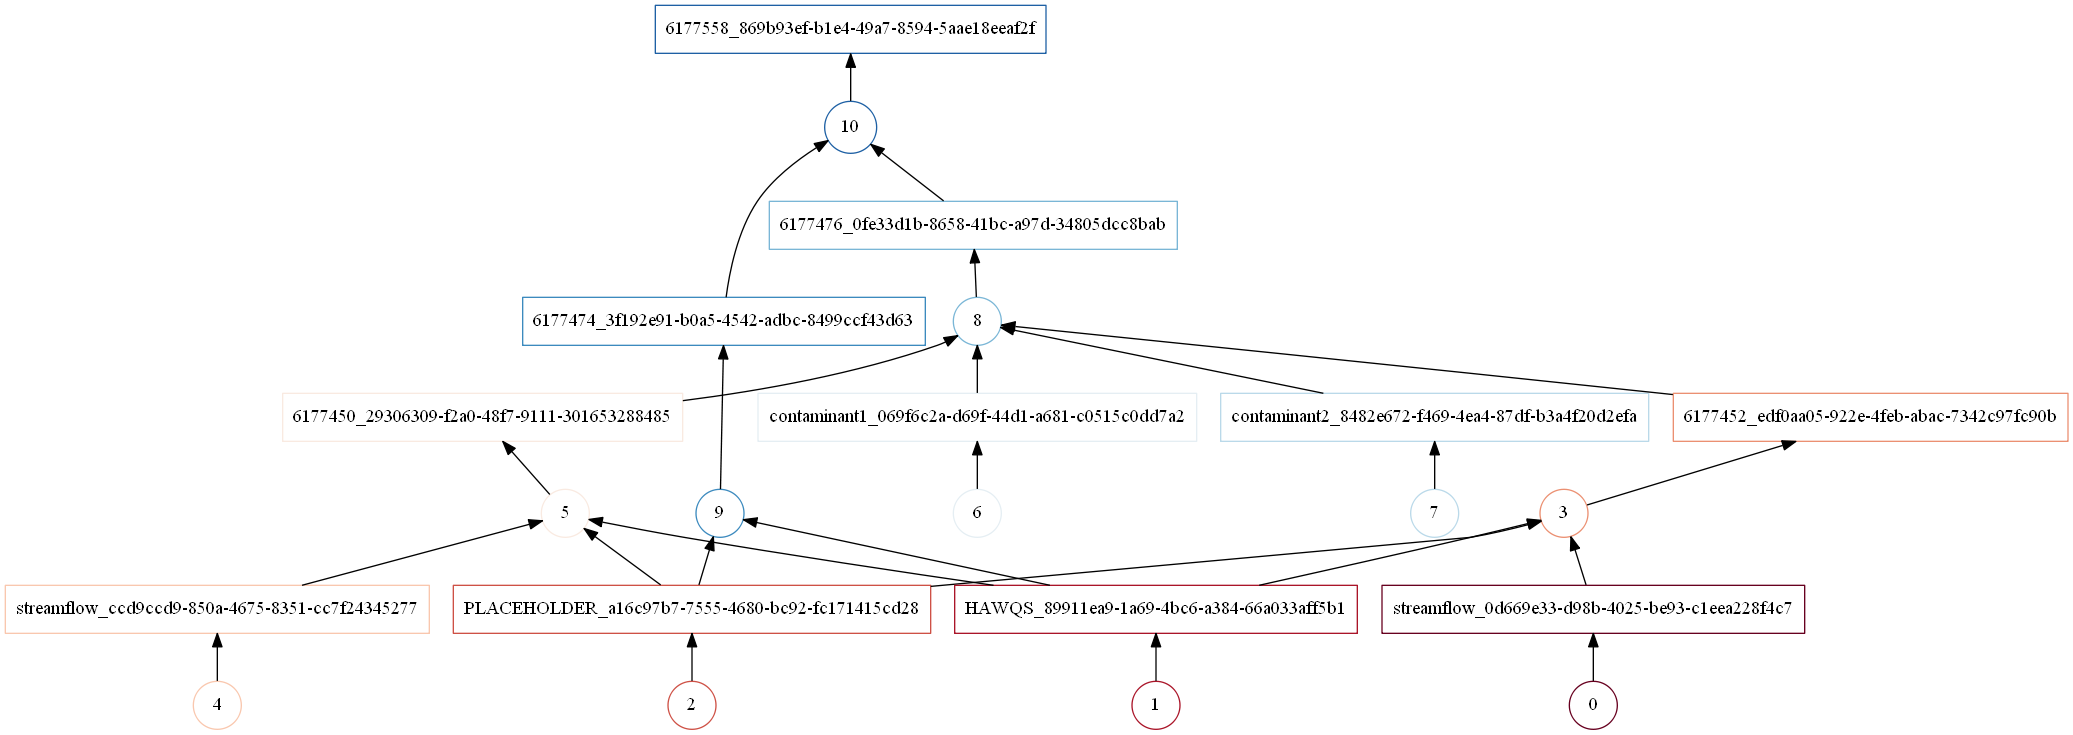

In [7]:
[print(f"{comid} : {c_id}") for comid, c_id in workflow.source_ids.items()]
print(workflow.pourpoint)
workflow.pourpoint.visualize("workflow-graph.png", color='order', verbose=True)

In [8]:
[print(f"{comid} : {c_id}") for comid, c_id in workflow.catchment_ids.items()]

6177452 : edf0aa05-922e-4feb-abac-7342c97fc90b
6177450 : 29306309-f2a0-48f7-9111-301653288485
6177476 : 0fe33d1b-8658-41bc-a97d-34805dcc8bab
6177474 : 3f192e91-b0a5-4542-adbc-8499ccf43d63
6177558 : 869b93ef-b1e4-49a7-8594-5aae18eeaf2f


[None, None, None, None, None]

In [9]:
%%time
# Request to get the simulation status from mongoDB
sim_status = MongoWorkflow.get_status(task_id=sim_id)
# del sim_status["input"]
sim_status

Wall time: 114 ms


{'_id': '70a21264-69ba-4cbe-937d-4177df318249',
 'type': 'workflow',
 'status': 'IN-PROGRESS',
 'update_time': '2021-06-01 08:11:34.412814',
 'message': None,
 'catchments': {'6177452': {'status': 'PENDING',
   'task_id': 'edf0aa05-922e-4feb-abac-7342c97fc90b',
   'message': None,
   'update_time': '2021-06-01 08:11:34.252507',
   'dependencies': {'streamflow': '0d669e33-d98b-4025-be93-c1eea228f4c7'}},
  '6177450': {'status': 'PENDING',
   'task_id': '29306309-f2a0-48f7-9111-301653288485',
   'message': None,
   'update_time': '2021-06-01 08:11:34.299845',
   'dependencies': {'streamflow': 'ccd9ccd9-850a-4675-8351-cc7f24345277'}},
  '6177476': {'status': 'PENDING',
   'task_id': '0fe33d1b-8658-41bc-a97d-34805dcc8bab',
   'message': None,
   'update_time': '2021-06-01 08:11:34.365239',
   'dependencies': {'contaminant1': '069f6c2a-d69f-44d1-a681-c0515c0dd7a2',
    'contaminant2': '8482e672-f469-4ea4-87df-b3a4f20d2efa'}},
  '6177474': {'status': 'PENDING',
   'task_id': '3f192e91-b0a5-45

In [10]:
%%time
# Executes the workflow, based upon the constructed graph
workflow.compute()

Wall time: 44.1 s


In [11]:
%%time
# Get the catchment status from mongoDB
catchment_id = "edf0aa05-922e-4feb-abac-7342c97fc90b"
catchment_status = MongoWorkflow.get_status(task_id=catchment_id)
# del catchment_status["input"]
catchment_status

Wall time: 82.2 ms


{'_id': 'edf0aa05-922e-4feb-abac-7342c97fc90b',
 'type': 'catchment',
 'sim_id': '70a21264-69ba-4cbe-937d-4177df318249',
 'status': 'COMPLETED',
 'update_time': '2021-06-01 08:12:14.921455',
 'message': None,
 'upstream': {},
 'dependencies': {'streamflow': '0d669e33-d98b-4025-be93-c1eea228f4c7'},
 'runtime': '10.3835',
 'timestamp': datetime.datetime(2021, 6, 1, 13, 11, 34, 268000)}

In [12]:
%%time
# Get the catchment data from mongoDB
catchment_data = MongoWorkflow.get_data(task_id=catchment_id)
del catchment_data["output"]
catchment_data

Wall time: 146 ms


{'_id': 'edf0aa05-922e-4feb-abac-7342c97fc90b',
 'type': 'catchment',
 'sim_id': '70a21264-69ba-4cbe-937d-4177df318249',
 'input': {},
 'status': 'COMPLETED',
 'update_time': '2021-06-01 08:12:14.921455',
 'message': None,
 'upstream': {},
 'dependencies': {'streamflow': '0d669e33-d98b-4025-be93-c1eea228f4c7'},
 'runtime': '10.3835',
 'timestamp': datetime.datetime(2021, 6, 1, 13, 11, 34, 268000)}

In [13]:
streamflow_dep_id = '0d669e33-d98b-4025-be93-c1eea228f4c7'
streamflow_data = MongoWorkflow.get_data(task_id=streamflow_dep_id)
streamflow_data

{'_id': '0d669e33-d98b-4025-be93-c1eea228f4c7',
 'type': 'dependency',
 'name': 'streamflow',
 'output': {},
 'input': {},
 'hash': '99914b932bd37a50b983c5e7c90ae93b',
 'timestamp': '2021-06-01 08:12:04.482955'}